Importing image datasets from kaggle

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download bayuokta/wayang-bagong-cepot-gareng-petruk-semar

wayang-bagong-cepot-gareng-petruk-semar.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip -qq wayang-bagong-cepot-gareng-petruk-semar.zip

replace images/images/test/wayang_bagong_(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Importing Library 

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Specifying Directory

In [ ]:
data_dir = "images"
train_dir= "images/train/"
val_dir = "images/val/"
test_dir = "images/test/"

Data Preprocessing

In [ ]:
# Make train  imagegeneratorclass 
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=10)

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=(150, 150),
                                                        batch_size=32,
                                                        class_mode='categorical')

Found 1350 images belonging to 5 classes.
Found 150 images belonging to 5 classes.


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-05-30 08:55:56--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   215MB/s    in 0.4s    

2022-05-30 08:55:56 (215 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

create the pre trained model using inception_v3 model from keras

In [ ]:
inception = InceptionV3(include_top=False,
                        input_shape=(150, 150, 3),
                        weights=None)
inception.load_weights(local_weights_file)

Make pre trained model layers non trainable

In [ ]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_564 (Conv2D)            (None, 74, 74, 32)   864         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_564 (Batch  (None, 74, 74, 32)  96          ['conv2d_564[0][0]']             
 Normalization)                                                                                   
                                                                                       

Specify base output used for the model

In [ ]:
default_layers = inception.get_layer('mixed7')
default_output = default_layers.output

create new model (masih belum bisa)

In [ ]:
final_output = layers.Flatten()(default_output)
final_output = layers.Dense(5, activation='softmax')(final_output)
new_model = Model(inputs=inception.input, outputs=final_output)
new_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_564 (Conv2D)            (None, 74, 74, 32)   864         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_564 (Batch  (None, 74, 74, 32)  96          ['conv2d_564[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      self.model.stop_training = True
      print("\nThe accuracy has reached > 99%!")
callbacks = myCallback()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('Wacayang_InceptionV3_Model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

Compile the model

In [ ]:
new_model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

Train the model

In [ ]:

history = new_model.fit(training_set,
                     epochs = 30,
                     validation_data = validation_generator,
                     callbacks = [callbacks, es, mc] )

Epoch 1/30
43/43 [==============================] - ETA: 0s - loss: 0.4024 - accuracy: 0.9074
Epoch 1: val_accuracy improved from -inf to 0.97333, saving model to Wacayang_InceptionV3_Model.h5
43/43 [==============================] - 56s 1s/step - loss: 0.4024 - accuracy: 0.9074 - val_loss: 0.2032 - val_accuracy: 0.9733
Epoch 2/30
43/43 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.9400
Epoch 2: val_accuracy improved from 0.97333 to 1.00000, saving model to Wacayang_InceptionV3_Model.h5
43/43 [==============================] - 52s 1s/step - loss: 0.2932 - accuracy: 0.9400 - val_loss: 0.1534 - val_accuracy: 1.0000
Epoch 3/30
43/43 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9489
Epoch 3: val_accuracy did not improve from 1.00000
43/43 [==============================] - 51s 1s/step - loss: 0.2389 - accuracy: 0.9489 - val_loss: 0.1291 - val_accuracy: 1.0000
Epoch 4/30
43/43 [==============================] - ETA: 0s - loss: 0.2037 - ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


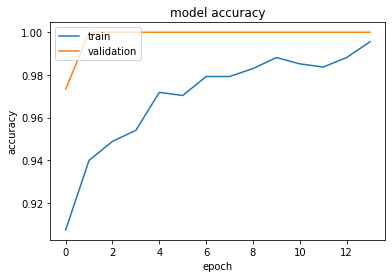

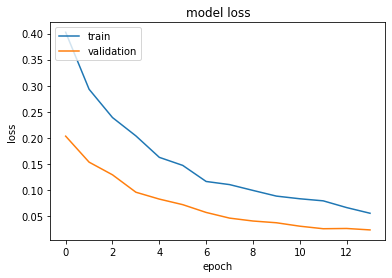

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Save model as .h5 file

In [ ]:
!mkdir -p saved_model_h5
new_model.save('saved_model_h5/Baseline Model.h5')

Evaluate Model

In [7]:
from keras.models import load_model
import cv2
import numpy as np
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
from PIL import Image

classes = ['bagong', 'cepot', 'gareng', 'petruk', 'semar']

loaded_model = load_model('Wacayang_InceptionV3_Model.h5')

image_testing = Image.open('/content/cepot.jpeg')
image_testing = np.array(image_testing.resize((150, 150))) / 255.0
image_testing.shape

image_testing = np.expand_dims(image_testing, axis=0)
print(image_testing.shape)

output = loaded_model.predict(image_testing)
best_index = np.argmax(output)
class_name = classes[best_index]

print(output)
print(best_index)

(1, 150, 150, 3)
[[8.3689031e-04 9.9833030e-01 1.2418639e-04 7.9874713e-05 6.2867266e-04]]
1


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Wacayang/test',
                                            target_size = (150, 150),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 150 images belonging to 5 classes.


In [12]:
score = loaded_model.evaluate(test_set, return_dict=True, verbose=0)
print(score)

{'loss': 0.15505318343639374, 'accuracy': 0.9933333396911621}
